# Set-Up

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
!pip install arch --quiet

import pandas as pd
import pandas_datareader.data as web

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller

from sklearn.metrics import mean_squared_error

from scipy.stats import probplot, moment

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')


In [4]:
def plot_correlogram(x, lags=None, title=None,size=(20,10)):
    lags = min(10, int(len(x)/5)) if lags is None else lags

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=size)

    x.plot(ax=axes[0][0], title='Residuals')

    xmax=max(x)
    xmin=min(x)

    print(xmin,xmax)

    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1,ylim=(xmin-.5,xmax+.5))

    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)

    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'

    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0],auto_ylims=True)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1],auto_ylims=True)

    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')

    fig.suptitle(title, fontsize=14)
    sns.despine()
    #fig.tight_layout()
    #fig.subplots_adjust(top=.9)

# NASDAQ

In [5]:
nasdaq = web.DataReader('NASDAQCOM', 'fred', '2000', '2020').squeeze()
nasdaq_returns = np.log(nasdaq).diff().dropna().mul(100) # rescale to faciliate optimization

-10.16841074672623 13.254644532142468


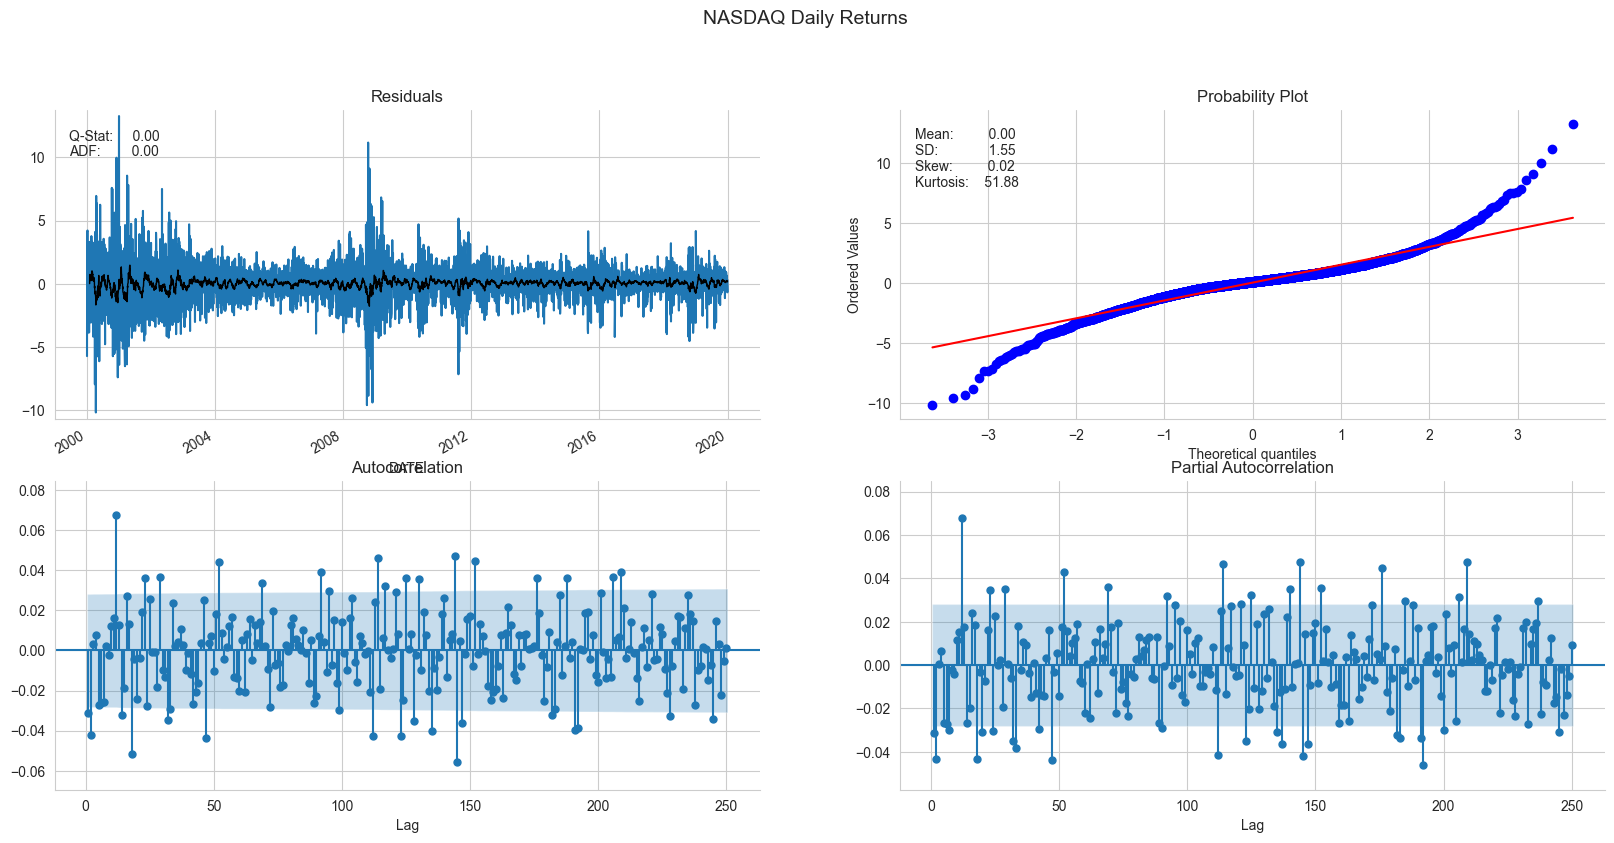

In [6]:
plot_correlogram(nasdaq_returns, lags=250, title='NASDAQ Daily Returns')

9.182097109761017e-12 175.2668646880814


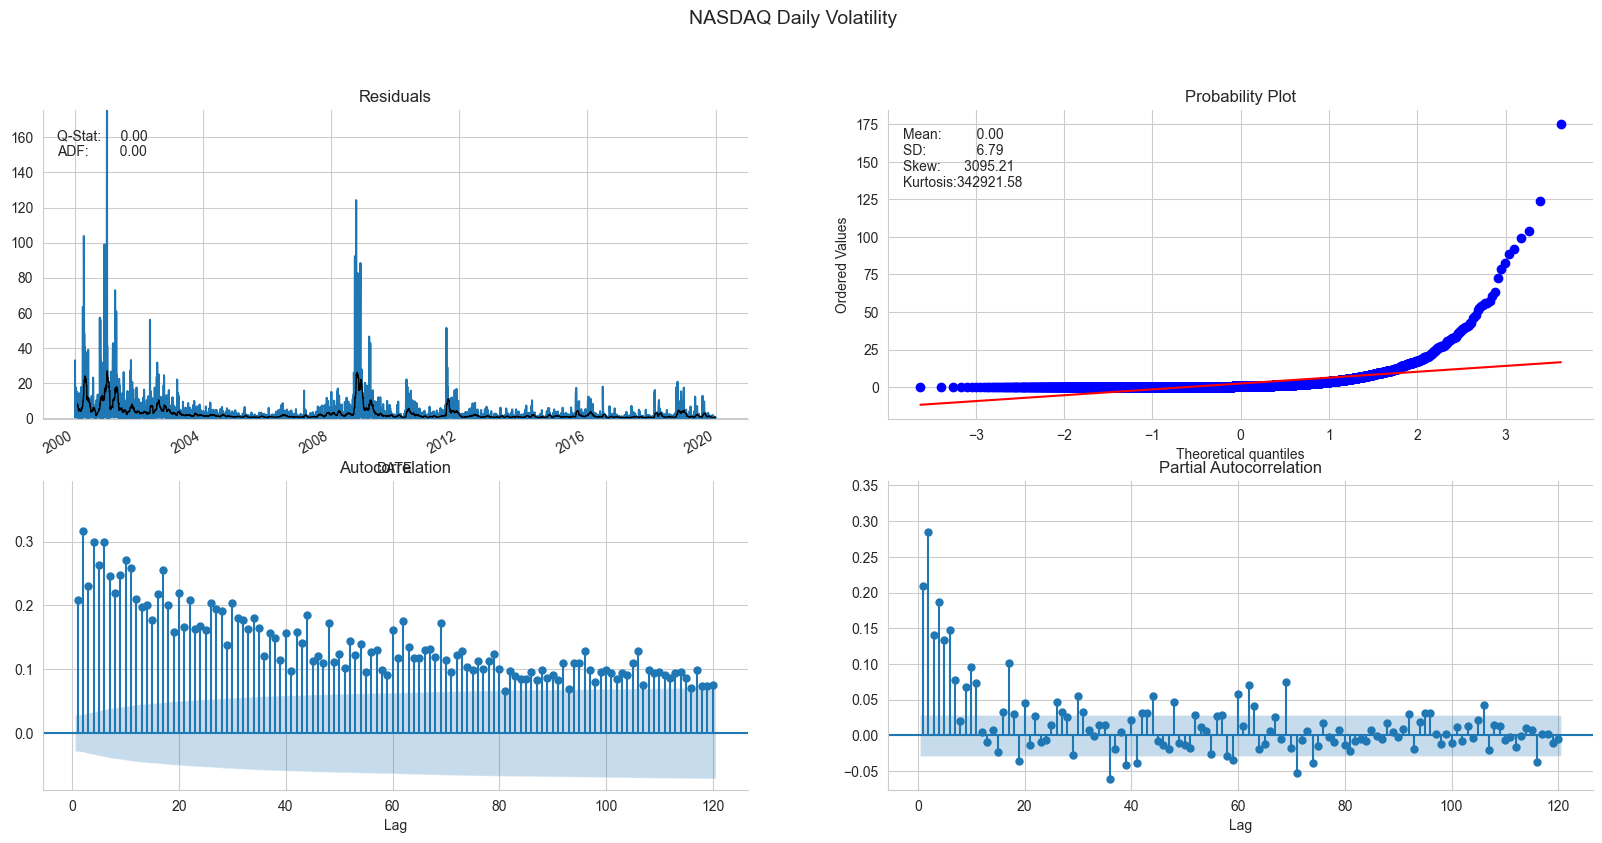

In [8]:
plot_correlogram(nasdaq_returns.sub(nasdaq_returns.mean()).pow(2), lags=120, title='NASDAQ Daily Volatility')

In [53]:
data.iloc[s: t]

DATE
2009-08-13    0.530431
2009-08-14   -1.193044
2009-08-17   -2.558960
2009-08-18    1.290553
2009-08-19    0.678701
                ...   
2019-12-19    0.671582
2019-12-20    0.423733
2019-12-23    0.231565
2019-12-24    0.080845
2019-12-27   -0.174985
Name: NASDAQCOM, Length: 2520, dtype: float64

In [57]:
data.iloc[t-1:t+2]

DATE
2019-12-27   -0.174985
2019-12-30   -0.675392
2019-12-31    0.297044
Name: NASDAQCOM, dtype: float64

In [71]:
trainsize = 10 * 252  # 10 years
data = nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05),
                           upper=nasdaq_returns.quantile(.95))
T = len(nasdaq_returns)
results = {}
#for p in range(1, 5):
#    for q in range(1, 5):
for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [72]:
s = pd.Series(results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)

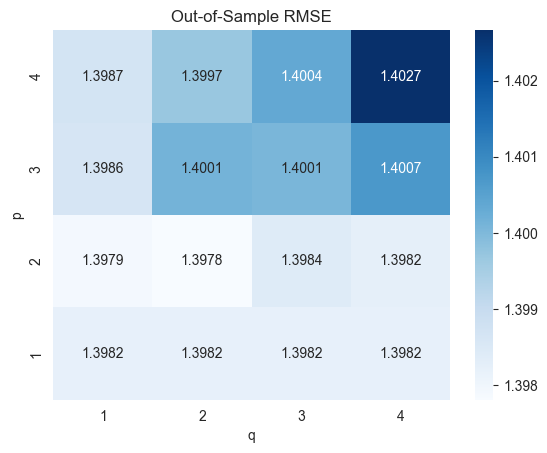

In [73]:
sns.heatmap(s, cmap='Blues', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE');

In [78]:
s==s.min().min()

q,1,2,3,4
p,,,,
4,False,False,False,False
3,False,False,False,False
2,False,True,False,False
1,False,False,False,False


In [ ]:
cands=[(1,1),(2,3)]

In [80]:
am = ConstantMean(nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05),
                                    upper=nasdaq_returns.quantile(.95)))

p,q = 2,2
print(f'(p,q) = ({p,q})')
am.volatility = GARCH(p, 0, q)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())

(p,q) = ((2, 2))
Iteration:      5,   Func. Count:     47,   Neg. LLF: 7254.9263258078345
Iteration:     10,   Func. Count:     86,   Neg. LLF: 7244.082421954562
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7244.081599456789
            Iterations: 13
            Function evaluations: 106
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              NASDAQCOM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7244.08
Distribution:                  Normal   AIC:                           14500.2
Method:            Maximum Likelihood   BIC:                           14539.1
                                        No. Observations:                 4851
Date:                Mon, Jul 10 2023   Df Residuals:                     4

-2.611562163543227 2.176682707617025


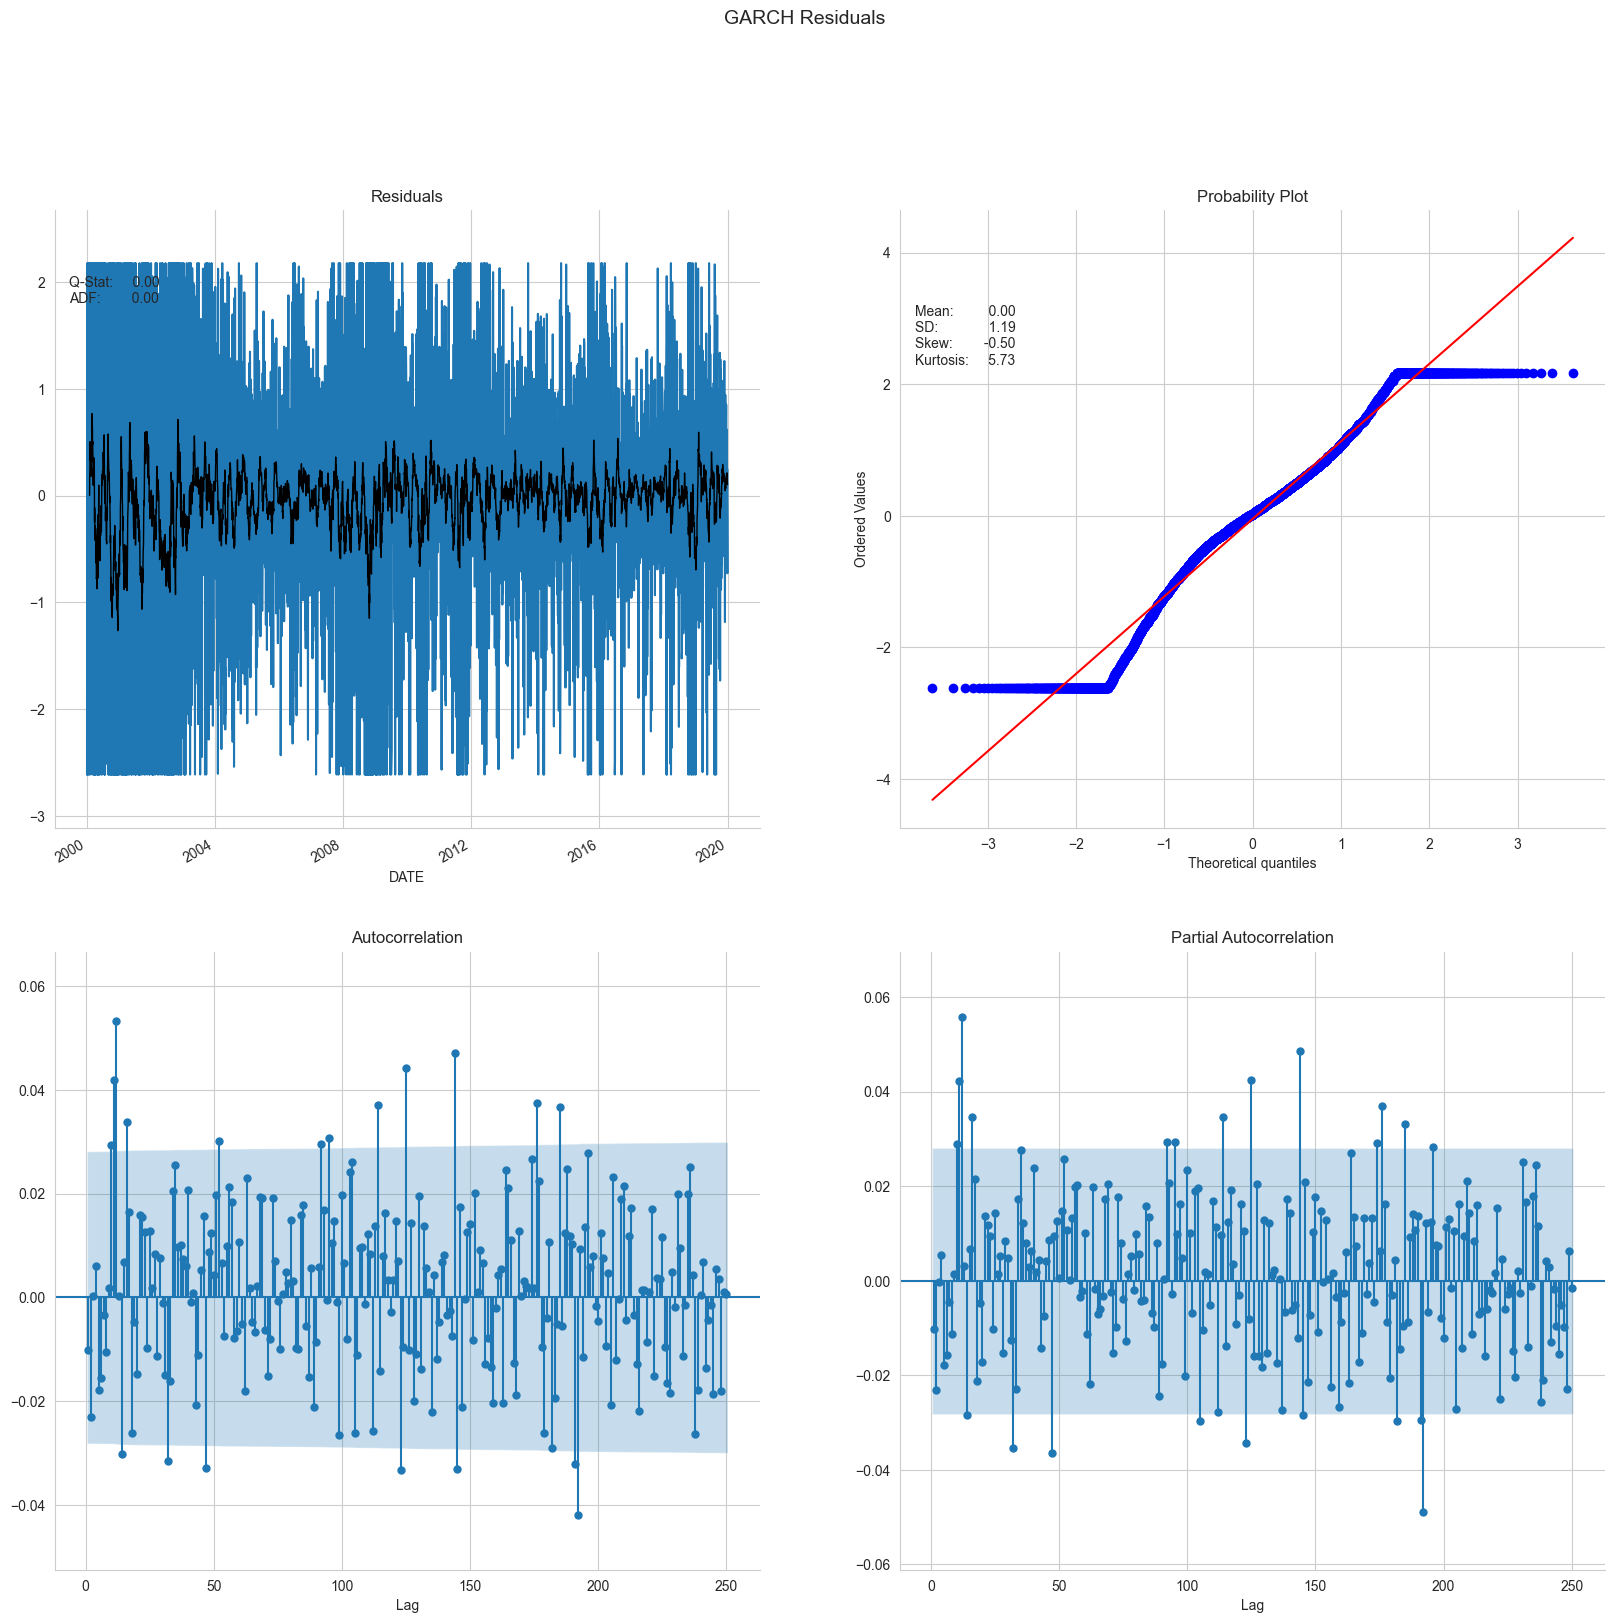

In [81]:
plot_correlogram(best_model.resid.dropna(),
                 lags=250,
                 title='GARCH Residuals',size=(20,20))

# VAR model

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error

In [ ]:
sns.set(style='whitegrid',
        context='notebook',
        color_codes=True)

In [ ]:
def plot_correlogram(x, lags=None, title=None):

    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

    x.plot(ax=axes[0][0], title='Time Series')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)

    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'

    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])

    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])

    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')

    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [ ]:
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

In [ ]:
sent = 'UMCSENT'
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1970', '2019-12').dropna()
df.columns = ['sentiment', 'ip']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1972-02-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  528 non-null    float64
 1   ip         528 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


In [ ]:
df.head()

,sentiment,ip
DATE,,
1972-02-01,92.8,35.8158
1972-05-01,88.6,37.3345
1972-08-01,95.2,37.0845
1972-11-01,90.7,39.3233
1973-02-01,81.9,39.9632


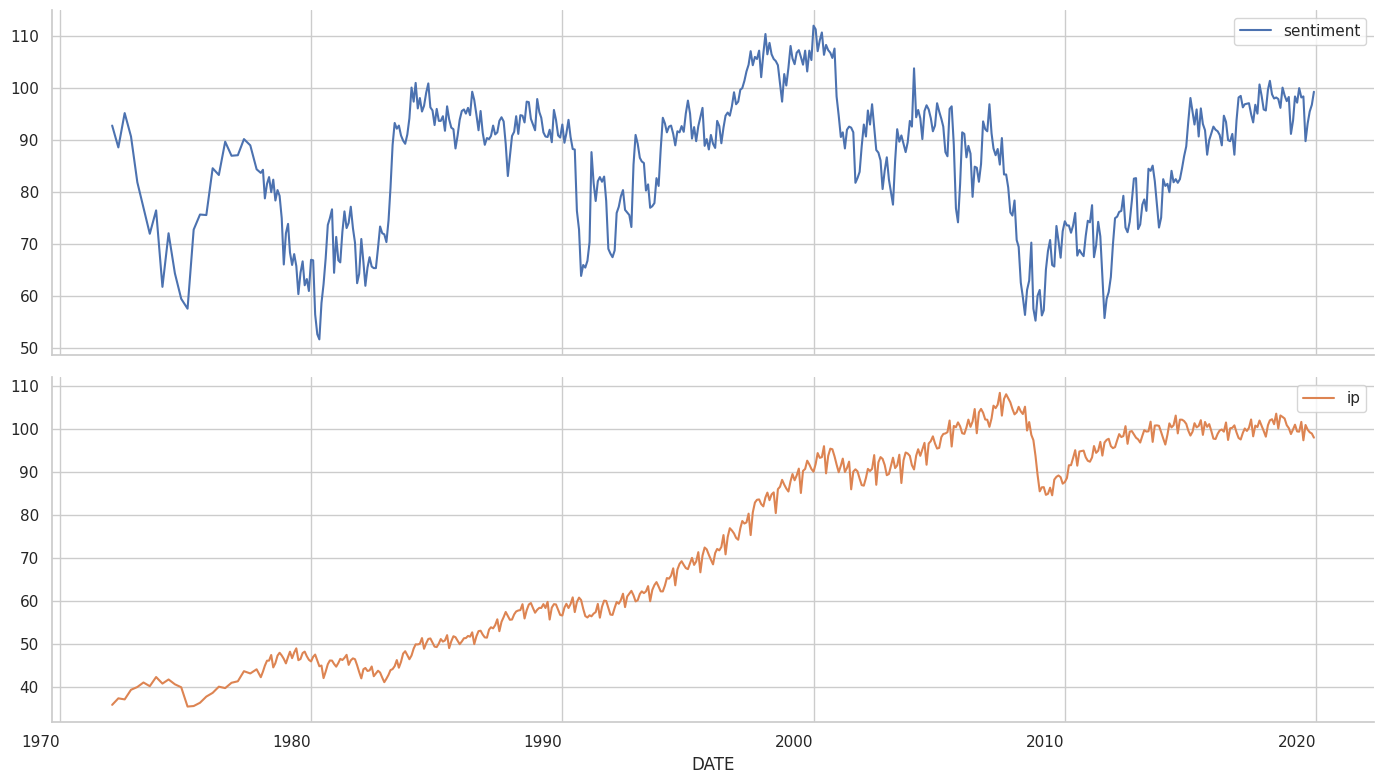

In [ ]:
df.plot(subplots=True, figsize=(14,8), rot=0)
sns.despine()
plt.tight_layout();

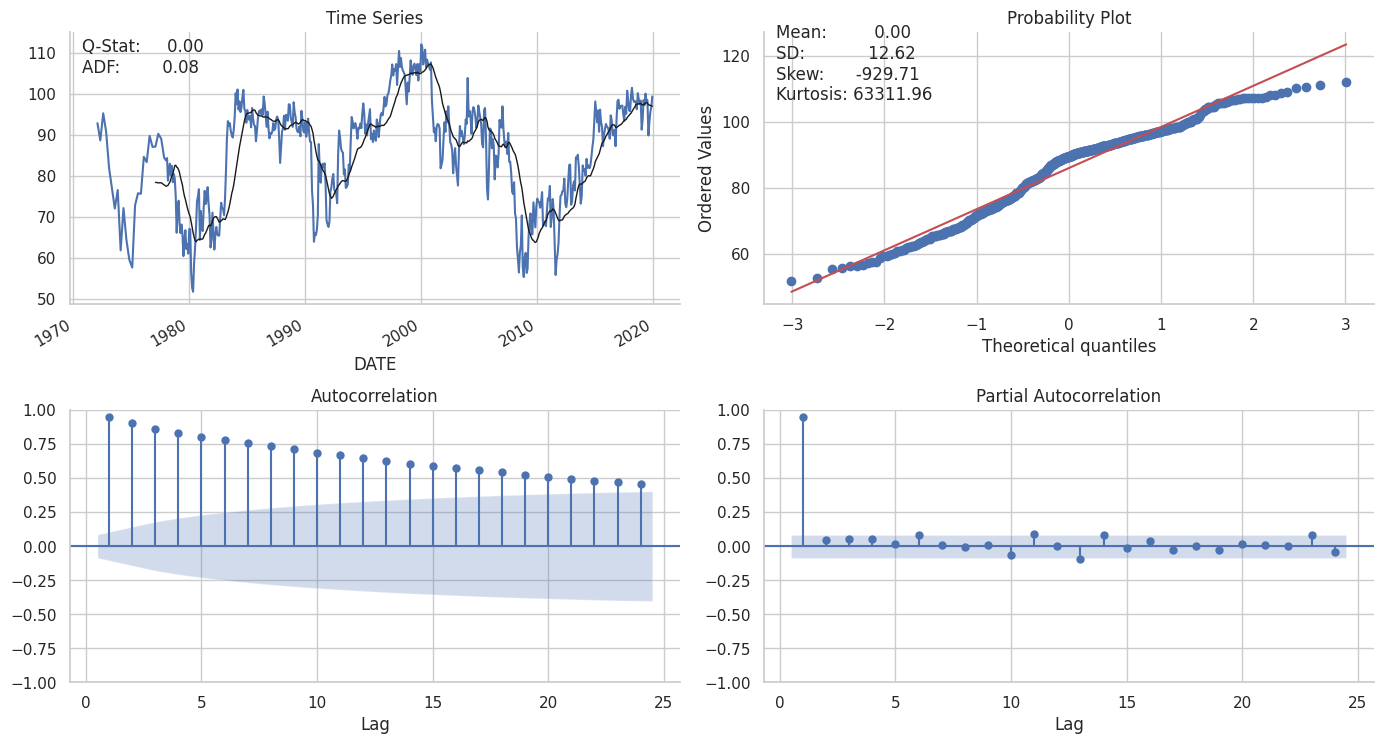

In [ ]:
plot_correlogram(df.sentiment, lags=24)

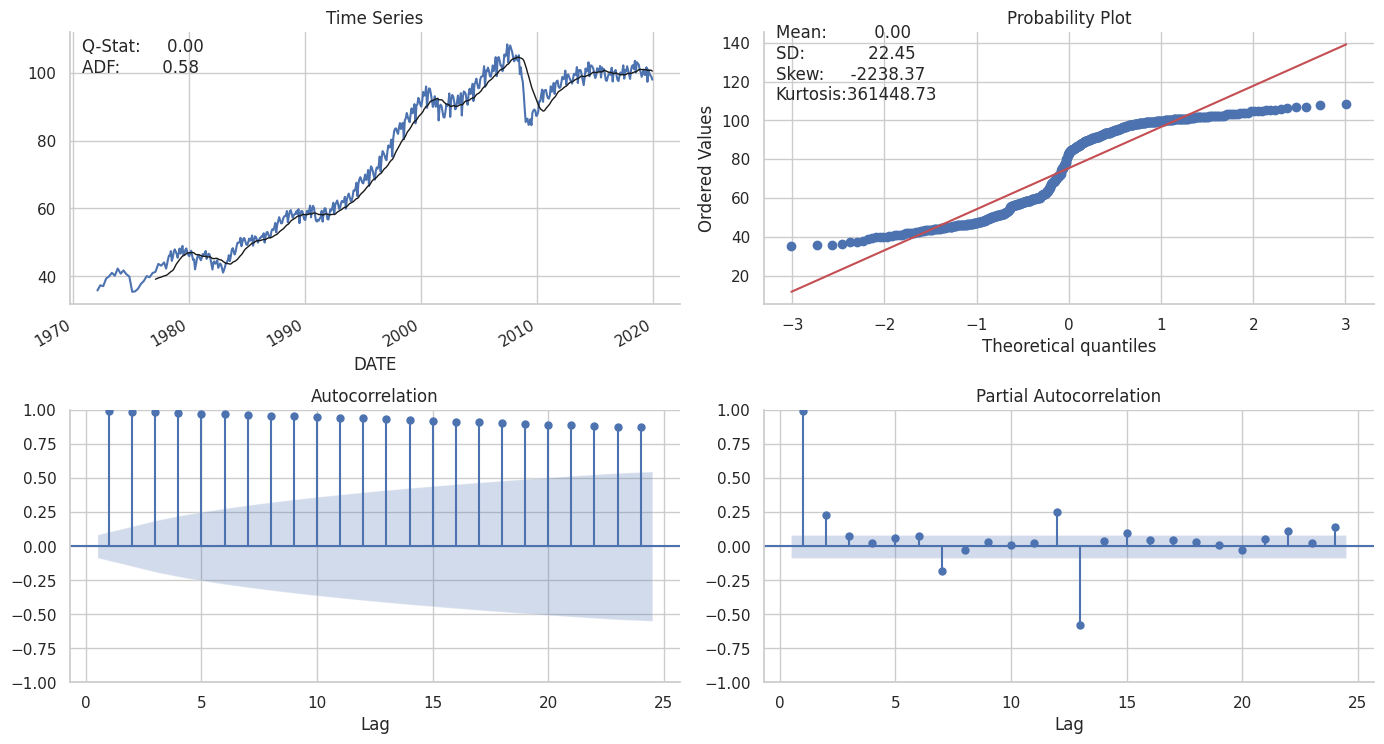

In [ ]:
plot_correlogram(df.ip, lags=24)

In [ ]:
df_transformed = pd.DataFrame({'ip': np.log(df.ip).diff(12),
                              'sentiment': df.sentiment.diff(12)}).dropna()

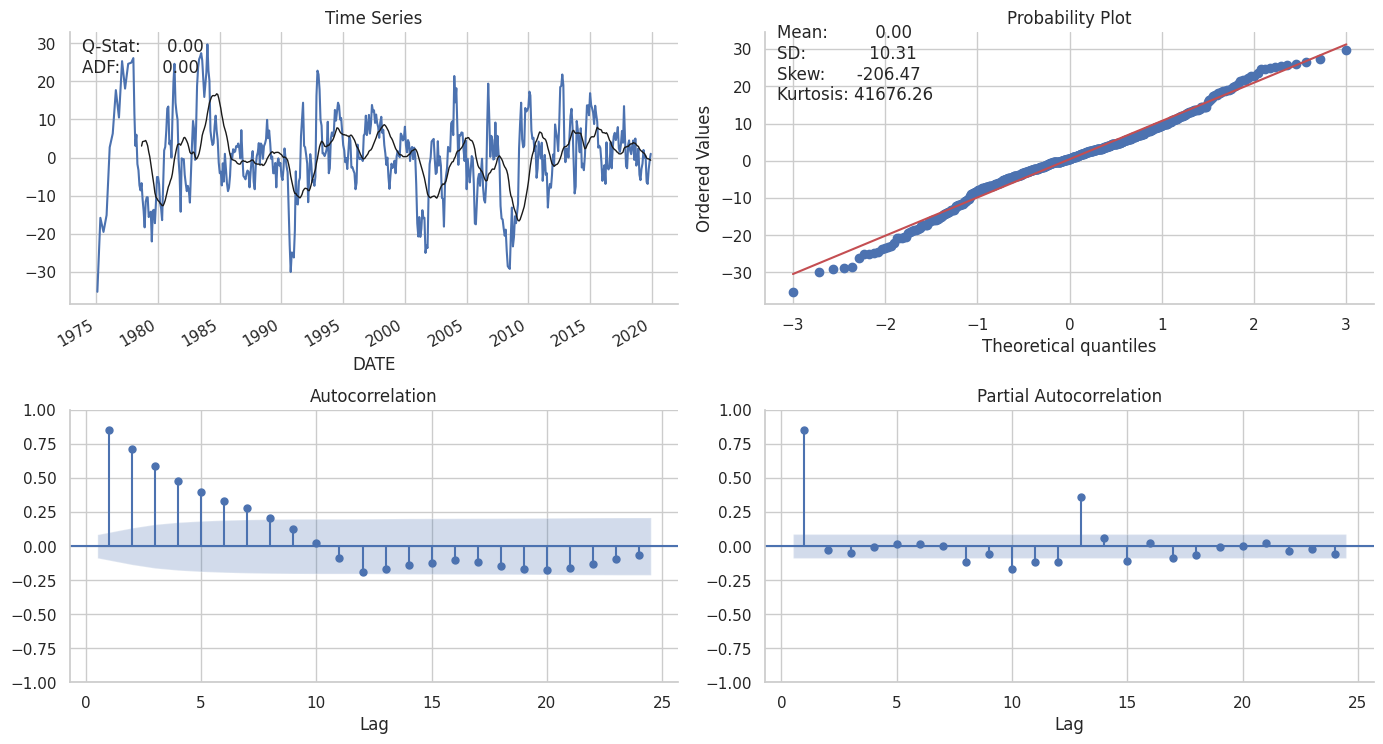

In [ ]:
plot_correlogram(df_transformed.sentiment, lags=24)

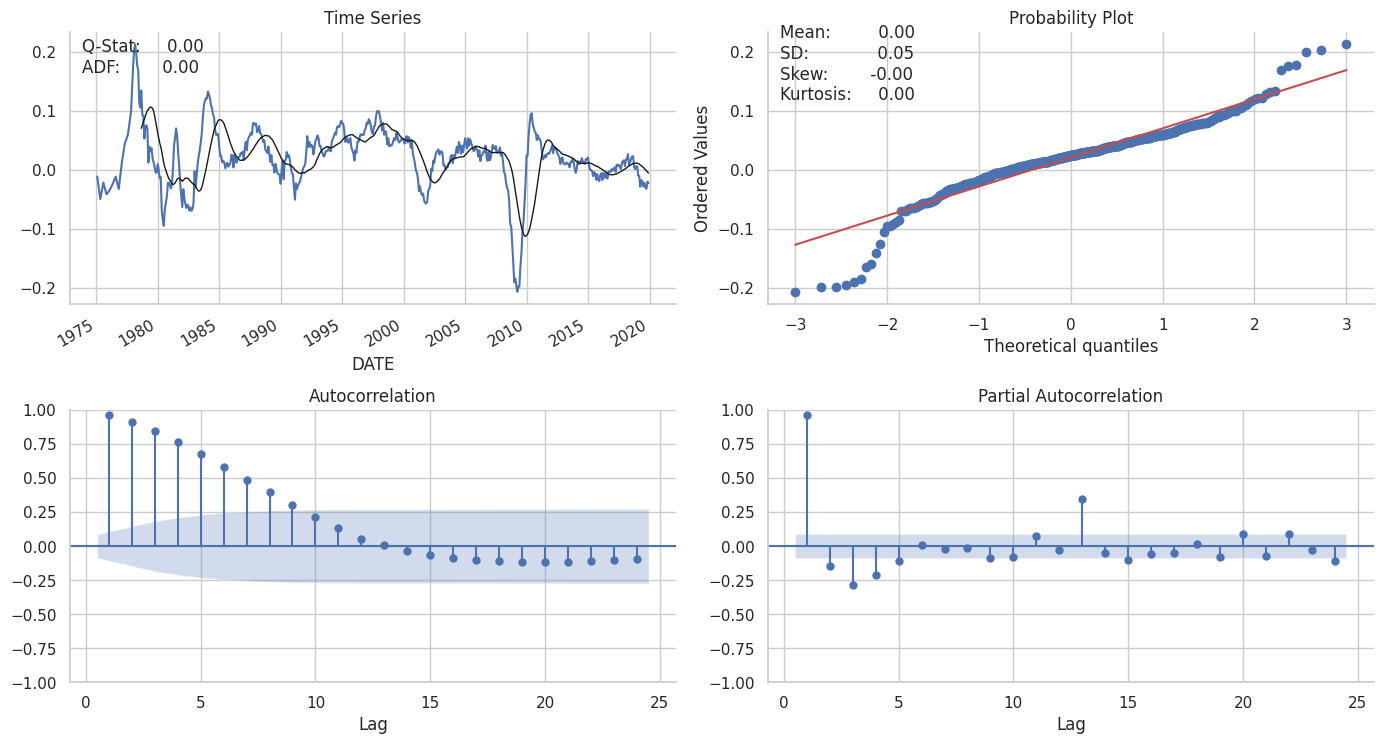

In [ ]:
plot_correlogram(df_transformed.ip, lags=24)


In [ ]:
test_unit_root(df_transformed)


,p-value
ip,0.02%
sentiment,0.00%


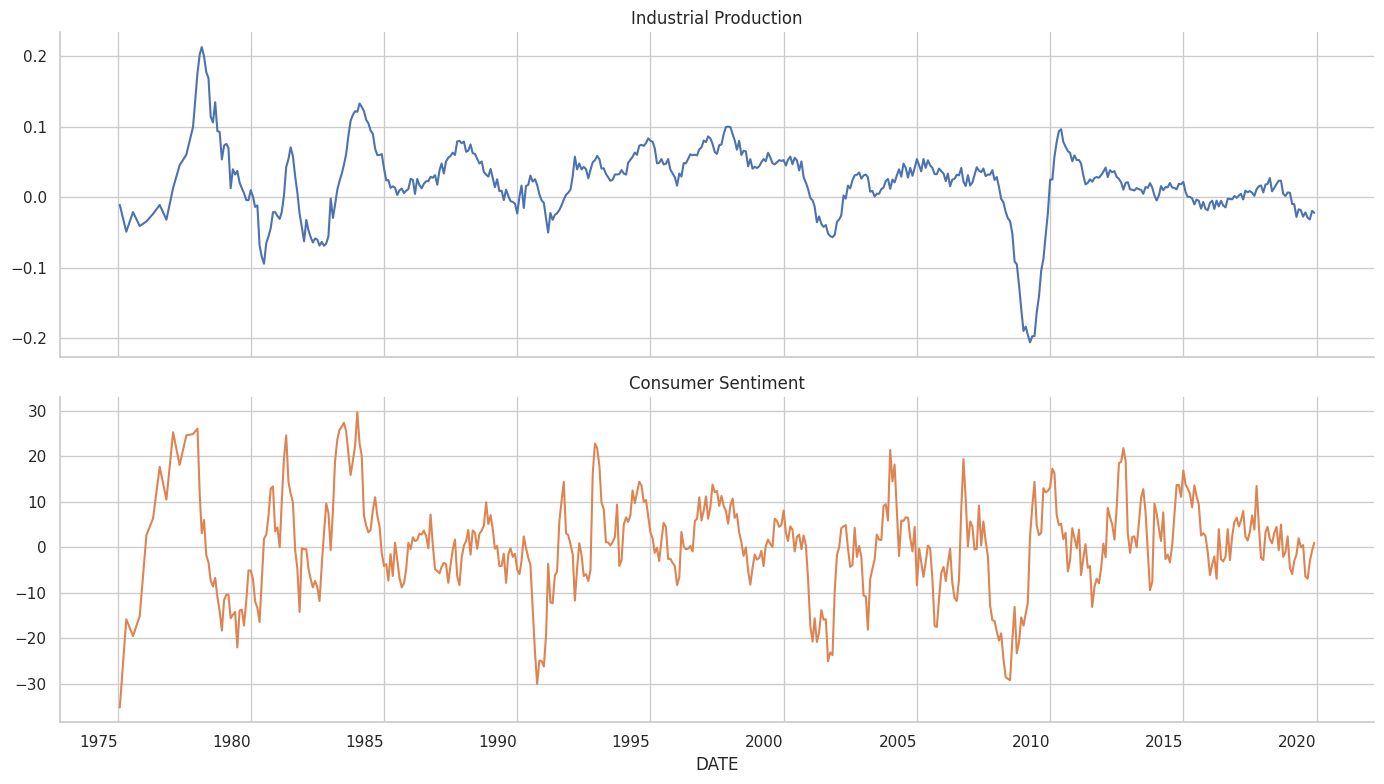

In [ ]:
df_transformed.plot(subplots=True, figsize=(14, 8),
                    title=['Industrial Production', 'Consumer Sentiment'],
                    legend=False,
                    rot=0)
sns.despine()
plt.tight_layout()

In [ ]:
df_transformed = df_transformed.apply(minmax_scale)

In [ ]:
model = VARMAX(df_transformed.loc[:'2017'], order=(1,1), trend='c').fit(maxiter=1000)

In [ ]:
print(model.summary())


                            Statespace Model Results                           
Dep. Variable:     ['ip', 'sentiment']   No. Observations:                  492
Model:                      VARMA(1,1)   Log Likelihood                1558.981
                           + intercept   AIC                          -3091.962
Date:                 Sun, 25 Jun 2023   BIC                          -3037.382
Time:                         21:48:08   HQIC                         -3070.530
Sample:                              0                                         
                                 - 492                                         
Covariance Type:                   opg                                         
Ljung-Box (L1) (Q):             0.15, 0.32   Jarque-Bera (JB):        154.26, 16.65
Prob(Q):                        0.70, 0.57   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.46, 1.02   Skew:                       0.18, 0.21
Prob(H) (two-sided):        

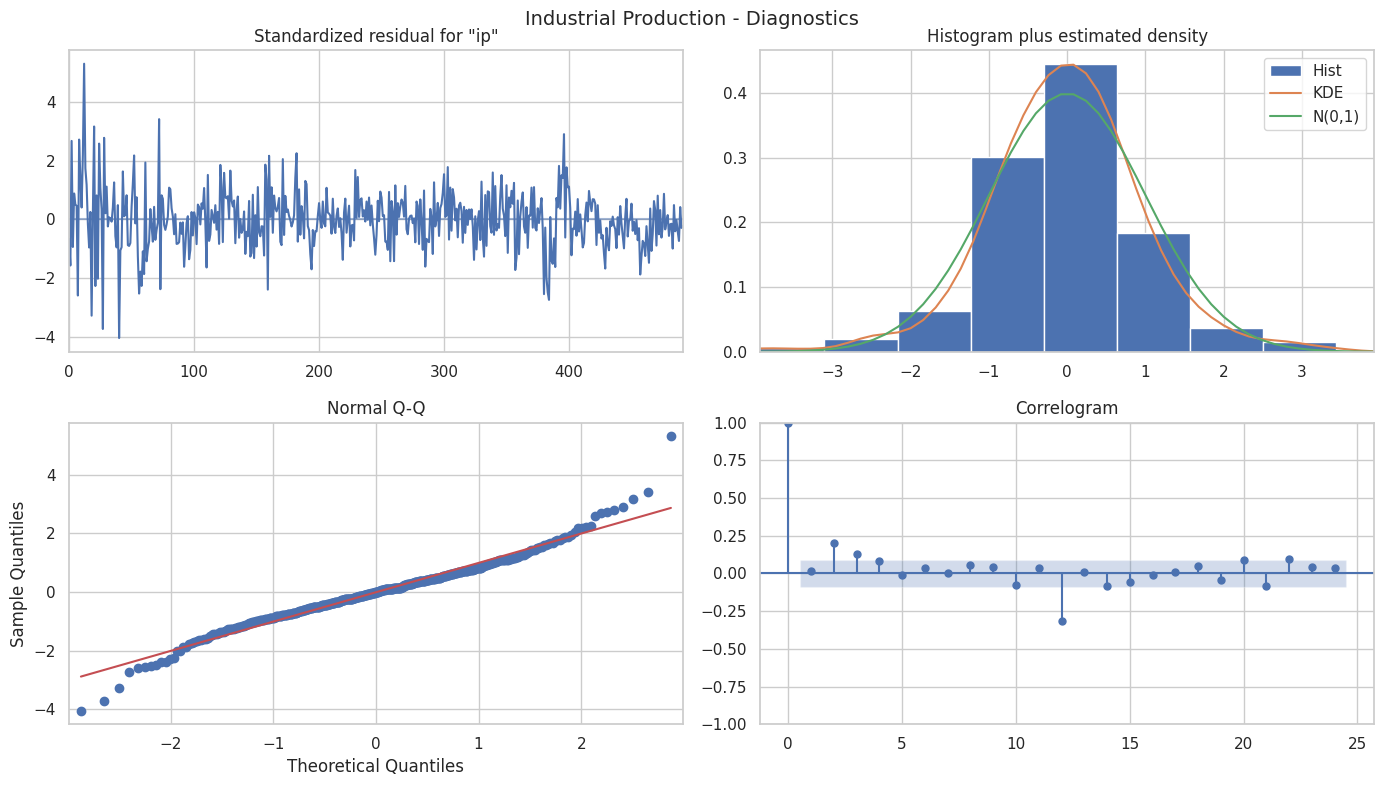

In [ ]:
model.plot_diagnostics(variable=0, figsize=(14,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

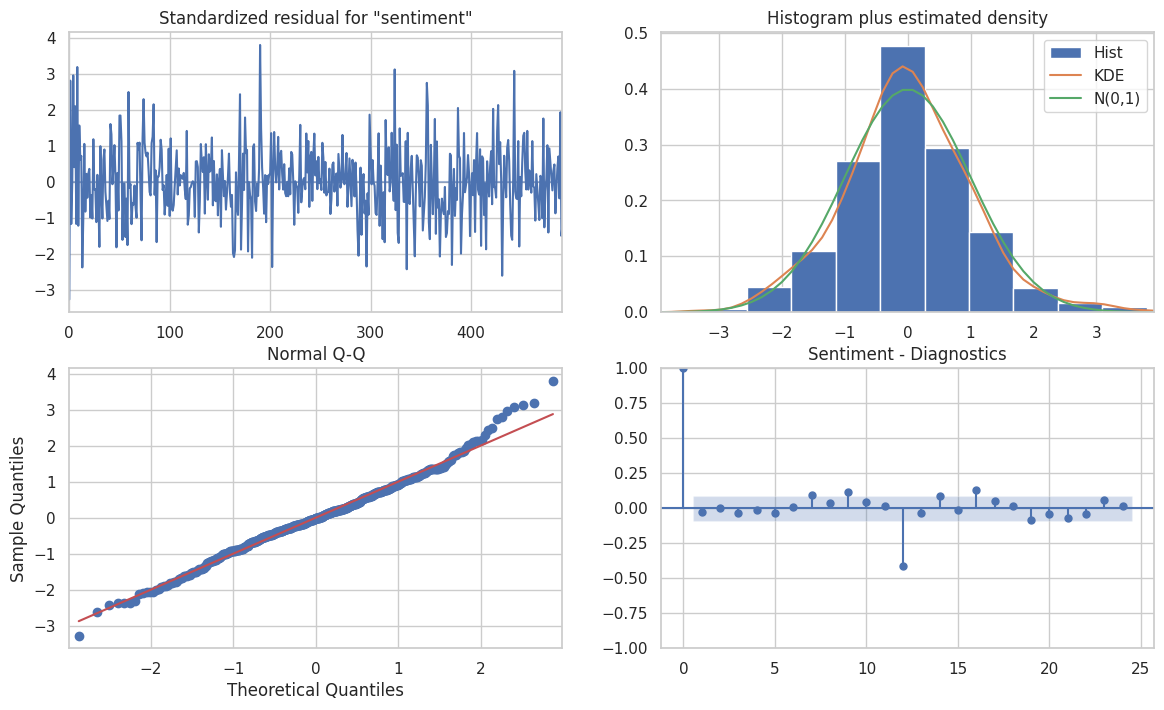

In [ ]:
model.plot_diagnostics(variable=1, figsize=(14,8), lags=24)
plt.title('Sentiment - Diagnostics');

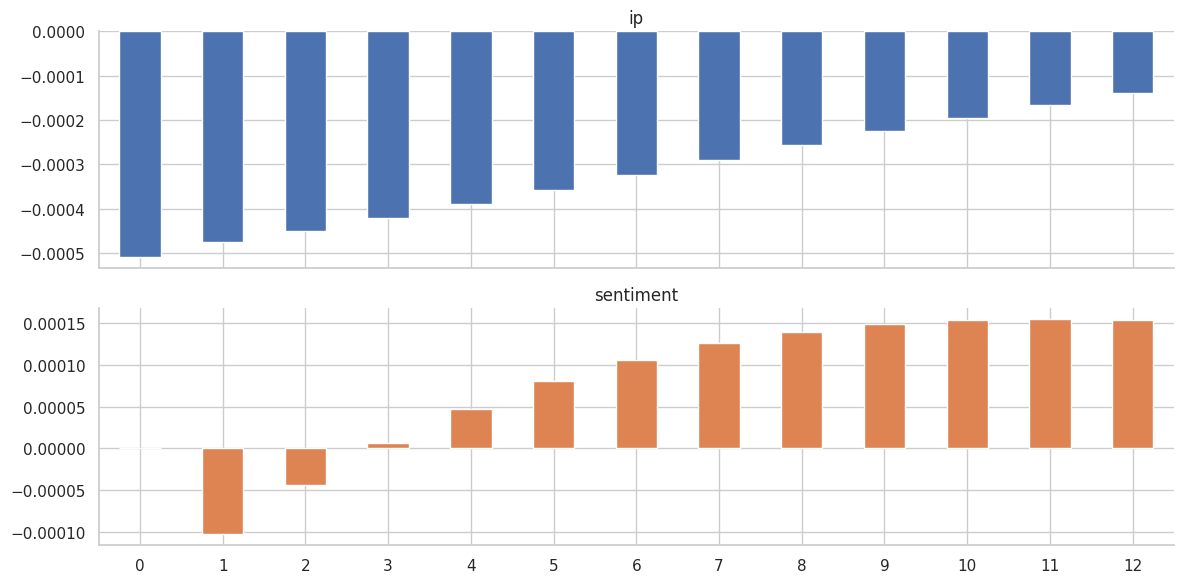

In [ ]:
median_change = df_transformed.diff().quantile(.5).tolist()
model.impulse_responses(steps=12,
                        impulse=median_change).plot.bar(subplots=True,
                                                        figsize=(12, 6),
                                                        rot=0,
                                                        legend=False)
sns.despine()
plt.tight_layout()

In [ ]:
n =len(df_transformed)
start = n-24

preds = model.predict(start=start+1, end=n)

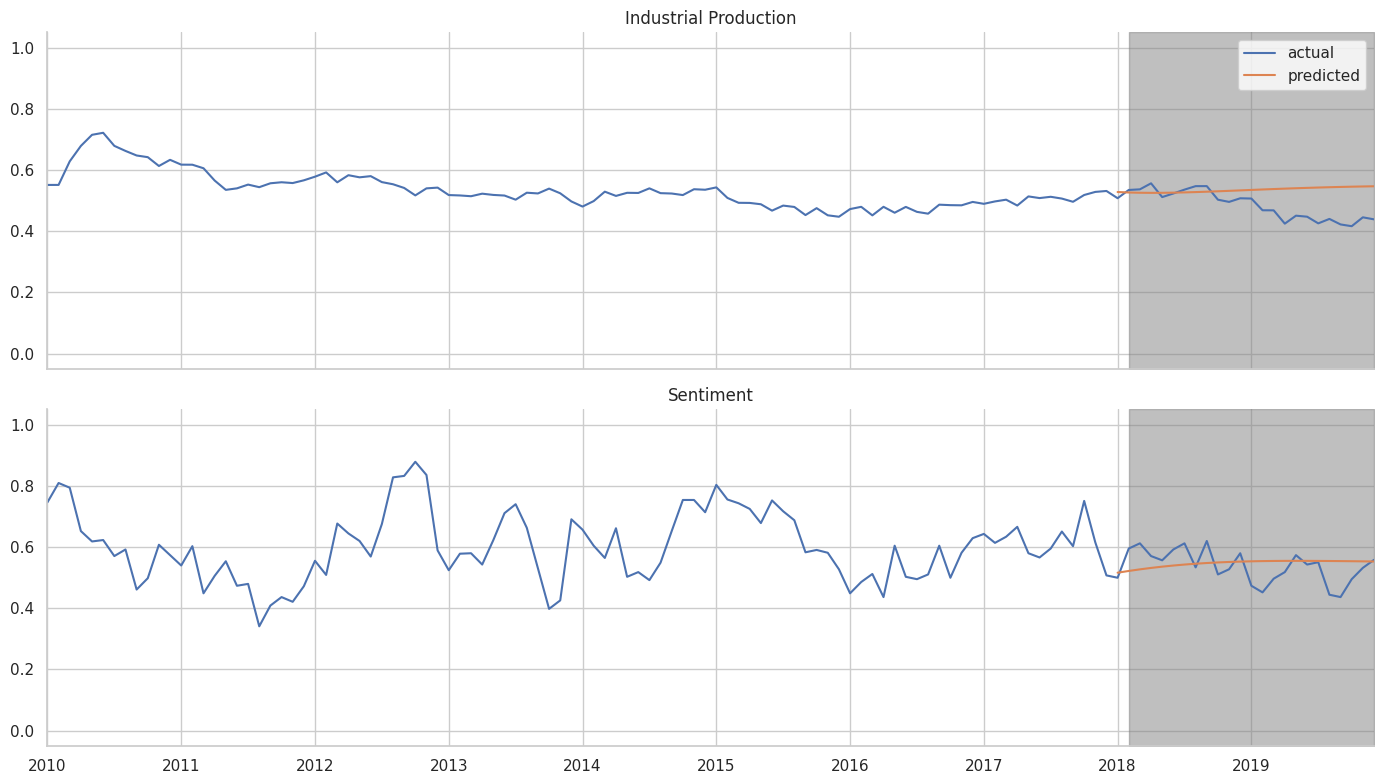

In [ ]:
preds.index = df_transformed.index[start:]

fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed.ip.loc['2010':].plot(ax=axes[0], label='actual', title='Industrial Production')
preds.ip.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.sentiment.loc['2010':].plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

In [ ]:
forecast = model.forecast(steps=24)


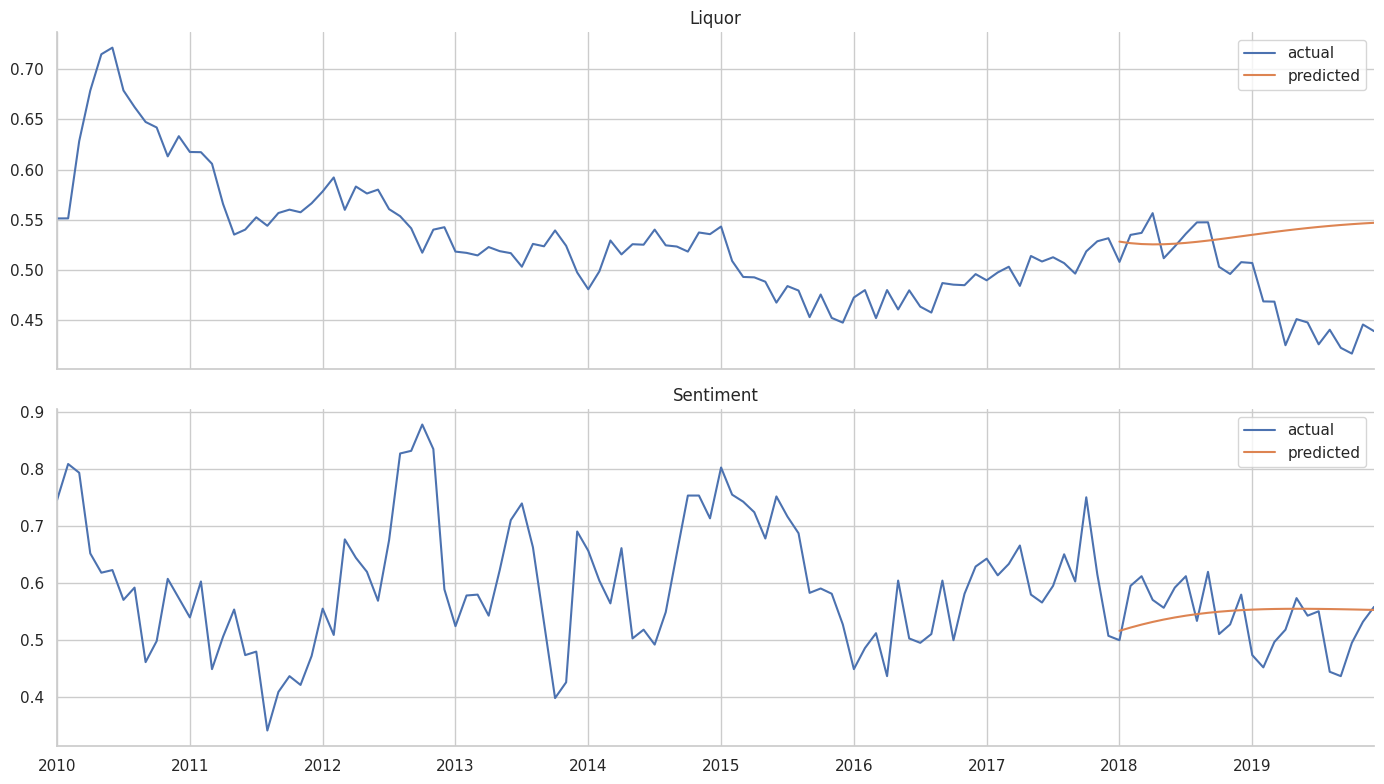

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed['2010':].ip.plot(ax=axes[0], label='actual', title='Liquor')
preds.ip.plot(label='predicted', ax=axes[0])
axes[0].legend()

df_transformed['2010':].sentiment.plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].legend()
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

In [ ]:
mean_absolute_error(forecast, df_transformed.iloc[492:])


0.052614831887274616

# Co-integration

In [5]:
%cd drive/MyDrive/ML_finance/jansen

/content/drive/MyDrive/ML_finance/jansen


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
from time import time
from pathlib import Path
from tqdm import tqdm

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')


In [9]:
DATA_PATH = Path('.', 'data')
STORE = DATA_PATH / 'assets.h5'

In [10]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [11]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

In [12]:
def remove_correlated_assets(df, cutoff=.99):
    corr = df.corr().stack()
    corr = corr[corr < 1]
    to_check = corr[corr.abs() > cutoff].index
    keep, drop = set(), set()
    for s1, s2 in to_check:
        if s1 not in keep:
            if s2 not in keep:
                keep.add(s1)
                drop.add(s2)
            else:
                drop.add(s1)
        else:
            keep.discard(s2)
            drop.add(s2)
    return df.drop(drop, axis=1)

In [13]:
def check_stationarity(df):
    results = []
    for ticker, prices in df.items():
        results.append([ticker, adfuller(prices, regression='ct')[1]])
    return pd.DataFrame(results, columns=['ticker', 'adf']).sort_values('adf')

In [14]:
def remove_stationary_assets(df, pval=.05):
    test_result = check_stationarity(df)
    stationary = test_result.loc[test_result.adf <= pval, 'ticker'].tolist()
    return df.drop(stationary, axis=1).sort_index()

In [15]:
def select_assets(asset_class='stocks', n=500, start=2010, end=2019):
    idx = pd.IndexSlice
    with pd.HDFStore(STORE) as store:
        df = (pd.concat([store[f'stooq/us/nasdaq/{asset_class}/prices'],
                         store[f'stooq/us/nyse/{asset_class}/prices']])
              # stooq download can have duplicate assets
              .loc[lambda df: ~df.index.duplicated()]
              .sort_index()
              .loc[idx[:, f'{start}':f'{end}'], :]
              .assign(dv=lambda df: df.close.mul(df.volume)))

    # select n assets with the highest average trading volume
    # we are taking a shortcut to simplify; should select
    # based on historical only, e.g. yearly rolling avg
    most_traded = (df.groupby(level='ticker')
                   .dv.mean()
                   .nlargest(n=n).index)

    df = (df.loc[idx[most_traded, :], 'close']
          .unstack('ticker')
          .ffill(limit=5)  # fill up to five values
          .dropna(axis=1))  # remove assets with any missing values

    df = remove_correlated_assets(df)
    return remove_stationary_assets(df).sort_index()

In [ ]:
for asset_class, n in [('etfs', 500), ('stocks', 250)]:
    df = select_assets(asset_class=asset_class, n=n)
    df.to_hdf('./data/data.h5', f'{asset_class}/close')

In [ ]:
def get_ticker_dict():
    with pd.HDFStore(STORE) as store:
        return (pd.concat([
            store['stooq/us/nyse/stocks/tickers'],
            store['stooq/us/nyse/etfs/tickers'],
            store['stooq/us/nasdaq/etfs/tickers'],
            store['stooq/us/nasdaq/stocks/tickers']
        ]).drop_duplicates().set_index('ticker').squeeze().to_dict())